## Importing libraries

In [333]:
import pandas as pd
import matplotlib as plt
import numpy as np
from fuzzywuzzy import process
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from weighted_correlation import weighted_correlation
from weighted_spearman import weighted_spearman

## Reading and cleaning the datasets

### Base dataset

Ambient air quality data from World Health Organisation (WHO)

[link](https://www.who.int/publications/m/item/who-ambient-air-quality-database-(update-jan-2024))

In [334]:
air_quality_df = pd.read_excel("who_ambient_air_quality_database_version_2024_(v6.1).xlsx", sheet_name="Update 2024 (V6.1)")


# Filter by US
air_quality_df = air_quality_df[air_quality_df["country_name"] == "United States of America"]

# Drop unnnecessary columns
air_quality_df = air_quality_df.drop(['country_name', 'version','reference','web_link', 'population_source','who_ms', 'type_of_stations', 'population', 'latitude', 'longitude', 'iso3', 'who_region', 'pm25_tempcov', 'pm10_tempcov','no2_tempcov'], axis=1)

# Remove state from city names
air_quality_df['city'] = air_quality_df['city'].str.split(' ').str[0]
air_quality_df['city'] = air_quality_df['city'].str.split('-').str[0]
# Leave only year 2020
air_quality_df = air_quality_df[air_quality_df['year'] == 2020.0]


### Additional dataset

Statistics of different medical conditions in USA cities.

[link](https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-County-Data-20/duw2-7jbt/about_data)

In [335]:
df = pd.read_csv("PLACES_Local_Data_for_Better_Health_County_Data_2022_release_20250320.csv")

df = df[df["Data_Value_Type"].str.contains("Age", na=False)]
df = df[df['TotalPopulation'] > 100000]

# Rename the city column
df = df.rename(columns={"LocationName": "city"})


# Drop unnecessary columns
df = df.drop(['StateAbbr', 'StateDesc', 'DataSource', 'Category', 'LocationID', 'CategoryID', 'DataValueTypeID', 'Geolocation', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Data_Value_Footnote_Symbol', 'MeasureId', 'Data_Value_Footnote' ], axis=1)
# First, let's identify the unique cities and measures
unique_cities = df['city'].unique()
unique_measures = df['Short_Question_Text'].unique()

# print(f"Number of unique cities: {len(unique_cities)}")
# print(f"Number of unique measures: {len(unique_measures)}")



# Create a pivot table with cities as index and measures as columns
health_df = df.pivot_table(
    index='city',
    columns='Measure',
    values='Data_Value',
    aggfunc='mean'  # Use mean if there are duplicate entries
)

population_df = df.groupby('city')['TotalPopulation'].first().reset_index()

# Reset the index to make 'city' a column again
health_df = health_df.reset_index()

# Drop columns that are not needed for the analysis
conditionsToDrop = [
'Current lack of health insurance among adults aged 18-64 years',
'Cervical cancer screening among adult women aged 21-65 years',
'Visits to dentist or dental clinic among adults aged >=18 years',
'Visits to doctor for routine checkup within the past year among adults aged >=18 years',
'Mammography use among women aged 50-74 years',
'Cholesterol screening among adults aged >=18 years',
'Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening',
'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
'Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years',
'All teeth lost among adults aged >=65 years',
'Arthritis among adults aged >=18 years',
'Binge drinking among adults aged >=18 years',
# 'Current smoking among adults aged >=18 years',
'Diagnosed diabetes among adults aged >=18 years',
'High cholesterol among adults aged >=18 years who have been screened in the past 5 years',
'No leisure-time physical activity among adults aged >=18 years',
'No leisure-time physical activity among adults aged >=18 years',
'Sleeping less than 7 hours among adults aged >=18 years',
'Stroke among adults aged >=18 years',
'Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure'
]
health_df = health_df.drop(conditionsToDrop, axis=1)

# All diseases
numberOfDiseases = len(list(df['Measure'].unique()))
print(numberOfDiseases)


health_df.head()
# print(new_df.columns)



30


Measure,city,Cancer (excluding skin cancer) among adults aged >=18 years,Chronic kidney disease among adults aged >=18 years,Chronic obstructive pulmonary disease among adults aged >=18 years,Coronary heart disease among adults aged >=18 years,Current asthma among adults aged >=18 years,Current smoking among adults aged >=18 years,Depression among adults aged >=18 years,Fair or poor self-rated health status among adults aged >=18 years,High blood pressure among adults aged >=18 years,Mental health not good for >=14 days among adults aged >=18 years,Obesity among adults aged >=18 years,Physical health not good for >=14 days among adults aged >=18 years
0,Ada,5.90,2.40,4.8,5.10,9.8,13.3,20.50,10.70,27.3,13.00,27.70,8.6
1,Adams,5.75,2.55,5.9,5.55,10.0,16.8,20.45,12.75,26.8,14.85,31.85,9.6
2,Aiken,6.00,2.90,6.8,6.10,9.9,18.8,22.00,15.70,35.2,15.50,37.30,11.0
3,Alachua,5.80,3.00,7.2,6.20,9.3,16.4,18.60,15.30,30.9,15.90,31.90,10.9
4,Alamance,5.80,3.00,6.5,6.10,9.6,19.3,23.40,14.60,34.0,15.10,35.90,10.5


### Matching cities using fuzzywuzzy

Since the formatting of some city names is slightly different in the two datasets, using fuzzywuzzy allows us to keep more of the data than simple string matching. In this block we replace the city names in 'city' column of air_quality_df with the corresponding names from health_df so that we can merge them later.

In [336]:
def find_best_match_city(city, citylist, threshold=95):
    best_match, score = process.extractOne(city, citylist)
    if score >= threshold:
        return best_match
    else: city

air_quality_df['city'] = air_quality_df['city'].apply(lambda x: find_best_match_city(x, unique_cities))

### Merging the two based on the matched cities

Now we use the previously handled 'city' column to merge our datasets.

In [337]:
merged_df = pd.merge(health_df, air_quality_df, on='city', how='inner')
merged_df = pd.merge(merged_df, population_df, on='city', how='left')
merged_df = merged_df.drop_duplicates(subset='city', keep='first')

# Optional: print some information about the merged DataFrame
# print(f"Shape of dataframe: {merged_df.shape}")
print("Columns with non-null values for:")
print(f"PM10 concentrations  - {merged_df['pm10_concentration'].notna().sum()}")
print(f"PM2.5 concentrations - {merged_df['pm25_concentration'].notna().sum()}")
print(f"NO2 concentrations   - {merged_df['no2_concentration'].notna().sum()}")

Columns with non-null values for:
PM10 concentrations  - 37
PM2.5 concentrations - 61
NO2 concentrations   - 30


## Testing the normality of the data

Before we can look for correlations in the data, we need to test for the normality of the data to be able to use appropriate formula for the correlation. Hence, we perform the Shapiro-Wilk normality test, because it is best suited for datasets with medium to large sample sizes. After running the test, we can conclude that some of the diseases appear to be non-normally distributed, therefore we must use a formula for correlation coefficient that is suitable for non-normal distributions.

In [338]:
array = merged_df.to_numpy()

p_values = []

# Get the column names for disease columns (skipping city, year, pollutants, and population)
disease_columns = merged_df.columns[1:13].tolist()
print(f"Testing normality for {len(disease_columns)} disease columns:")
print("-"*110)

# Run Shapiro-Wilk test for each disease column
for i, col_name in enumerate(disease_columns):
    disease_data = merged_df[col_name].dropna().values
    
    stat, p_value = shapiro(disease_data)
    p_values.append(p_value)
    
    result = "potentially normal" if p_value >= 0.05 else "non-normal"
    
    print(f"{col_name:70} | {result:20} | p={p_value:.3f}")


# Count how many p-values are less than 0.05 (indicating non-normal distribution)
non_normal_count = sum(p < 0.05 for p in p_values)
print("-"*110)
col_name = "Potentially normal"
print(f"{col_name:70} | {len(p_values) - non_normal_count}")
col_name = "Non-normal"
print(f"{col_name:70} | {non_normal_count}")


Testing normality for 12 disease columns:
--------------------------------------------------------------------------------------------------------------
Cancer (excluding skin cancer) among adults aged >=18 years            | non-normal           | p=0.000
Chronic kidney disease among adults aged >=18 years                    | potentially normal   | p=0.114
Chronic obstructive pulmonary disease among adults aged >=18 years     | potentially normal   | p=0.668
Coronary heart disease among adults aged >=18 years                    | potentially normal   | p=0.260
Current asthma among adults aged >=18 years                            | potentially normal   | p=0.063
Current smoking among adults aged >=18 years                           | potentially normal   | p=0.458
Depression among adults aged >=18 years                                | potentially normal   | p=0.538
Fair or poor self-rated health status among adults aged >=18 years     | potentially normal   | p=0.217
High blood pres

## Weighted spearman's correlation matrix

We use spearman's correlation, because it's well suited for non-normally distributed data. Additionally we use the populations of the cities as weights to take into account differently sized cities.

### Creating the correlation and p-value matrixes

Here we create the correlation matrix which includes the correlation coefficient for each pollutant-disease pair. We also create a corresponding p-value matrix, since calculating the p-value for weighted spearman's correlation afterwards is hard.

In [339]:
# Pollutant columns, we choose to exlude NO2 here, since there was less data on that one then the other
# pollutants, and the relaibility of the data appeared to be worse, since the measurements were less frequent.
pollutants = ['pm10_concentration', 'pm25_concentration']

# Disease columns
disease_columns = [col for col in health_df.columns if col != 'city']

# Create a correlation matrix between pollutants and diseases
correlation_matrix = pd.DataFrame(index=disease_columns, columns=pollutants)
p_value_matrix = pd.DataFrame(index=disease_columns, columns=pollutants)

# Extract weights (population values)
weights = merged_df['TotalPopulation']

# Calculate weighted correlation for each pollutant-disease pair
for disease in disease_columns:
    for pollutant in pollutants:
        # Extract the data
        data_i = merged_df[disease]
        data_j = merged_df[pollutant]
        
        # Create mask for non-NaN values in both columns
        mask = ~data_i.isna() & ~data_j.isna()
        
        # Skip if insufficient data
        if mask.sum() < 3:
            correlation_matrix.loc[disease, pollutant] = np.nan
            p_value_matrix.loc[disease, pollutant] = np.nan
            continue
        
        # Calculate weighted correlation using the function
        try:
            corr_value, p_value = weighted_spearman(
                data_i[mask].values, 
                data_j[mask].values, 
                weights[mask].values
            )
            correlation_matrix.loc[disease, pollutant] = corr_value
            p_value_matrix.loc[disease, pollutant] = p_value
            # print(f"{disease} and {pollutant}: {corr_value}, p={p_value}")
        except Exception as e:
            print(f"Error calculating correlation for {disease} and {pollutant}: {e}")
            correlation_matrix.loc[disease, pollutant] = np.nan
            p_value_matrix.loc[disease, pollutant] = np.nan

### Displaying correlation matrix without p-values

We generate the correlation matrix between airpollutants and medical conditions, since it is the easiest way to get a comprehensive view of all the correlations. 

Smoking amongst adults is included in the visualisation even though it's not a medical condition, we will come back to that later.

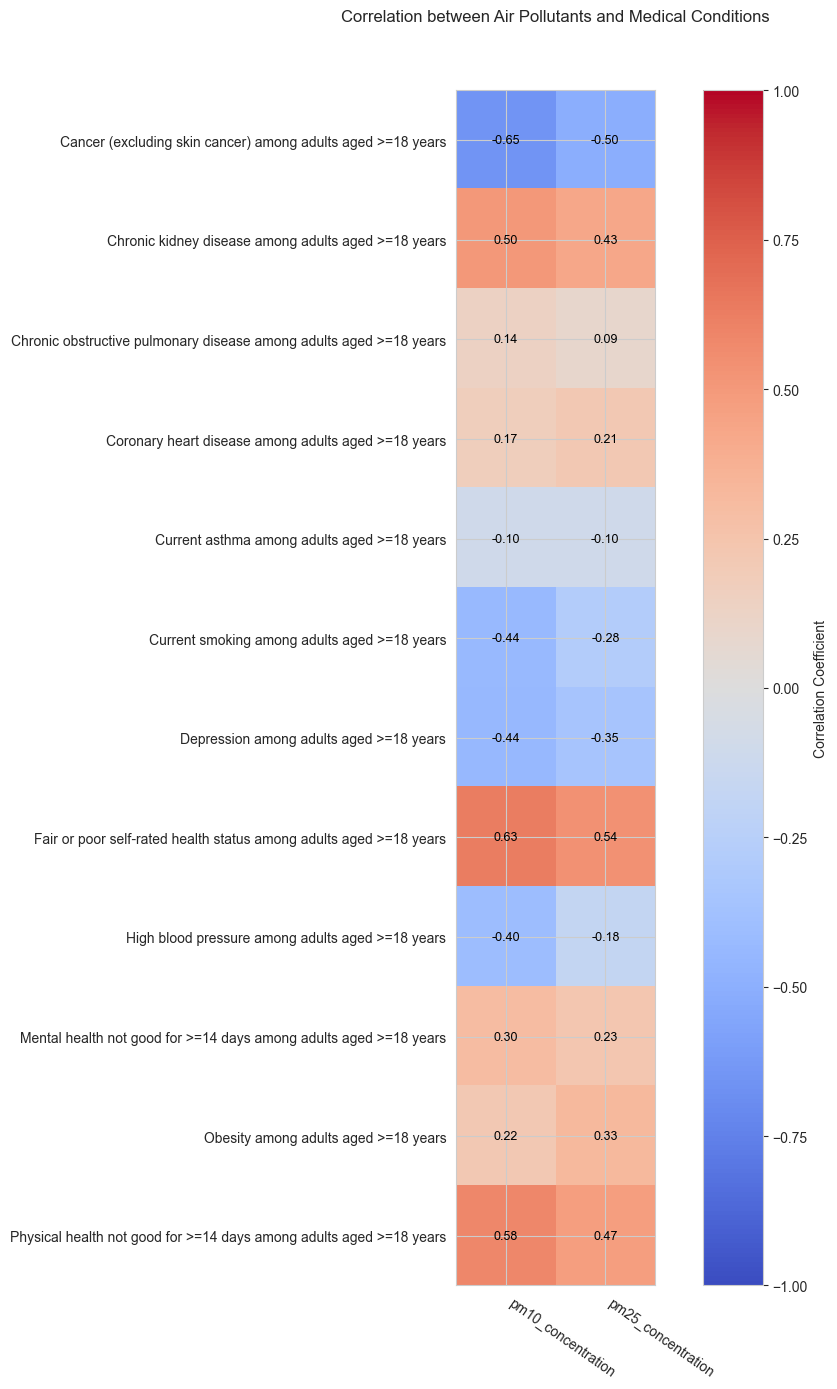

In [340]:
# Extract and transpose the correlation matrix - diseases as rows and pollutants as columns
disease_pollutant_corr = correlation_matrix.loc[disease_columns, pollutants]

# Visualize the correlation matrix as a heatmap using matplotlib
plt.figure(figsize=(10, 14))

# Convert correlation values to float
disease_pollutant_corr = disease_pollutant_corr.astype(float)

# Create the heatmap
im = plt.imshow(disease_pollutant_corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

# Add labels and title
plt.title('Correlation between Air Pollutants and Medical Conditions', pad=50)
plt.xticks(np.arange(len(pollutants)), pollutants, rotation=-35, ha='left')
plt.yticks(np.arange(len(disease_columns)), disease_columns, rotation=0)  # Changed rotation to 0

# Add correlation values as text annotations
for i in range(len(disease_columns)):
    for j in range(len(pollutants)):
        corr_value = disease_pollutant_corr.iloc[i, j]
        
        # Format the correlation value
        if pd.notna(corr_value):
            corr_text = f'{corr_value:.2f}'
            plt.text(j, i, corr_text, ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.savefig('corr_weighted_spearman.png')
plt.show()


### Generating correlation matrix with p-values


Now we generate the correlation matrix with the corresponding p-values to better understand the results. Correlations that are not statistically significant with 5% significanse level are grayed out.

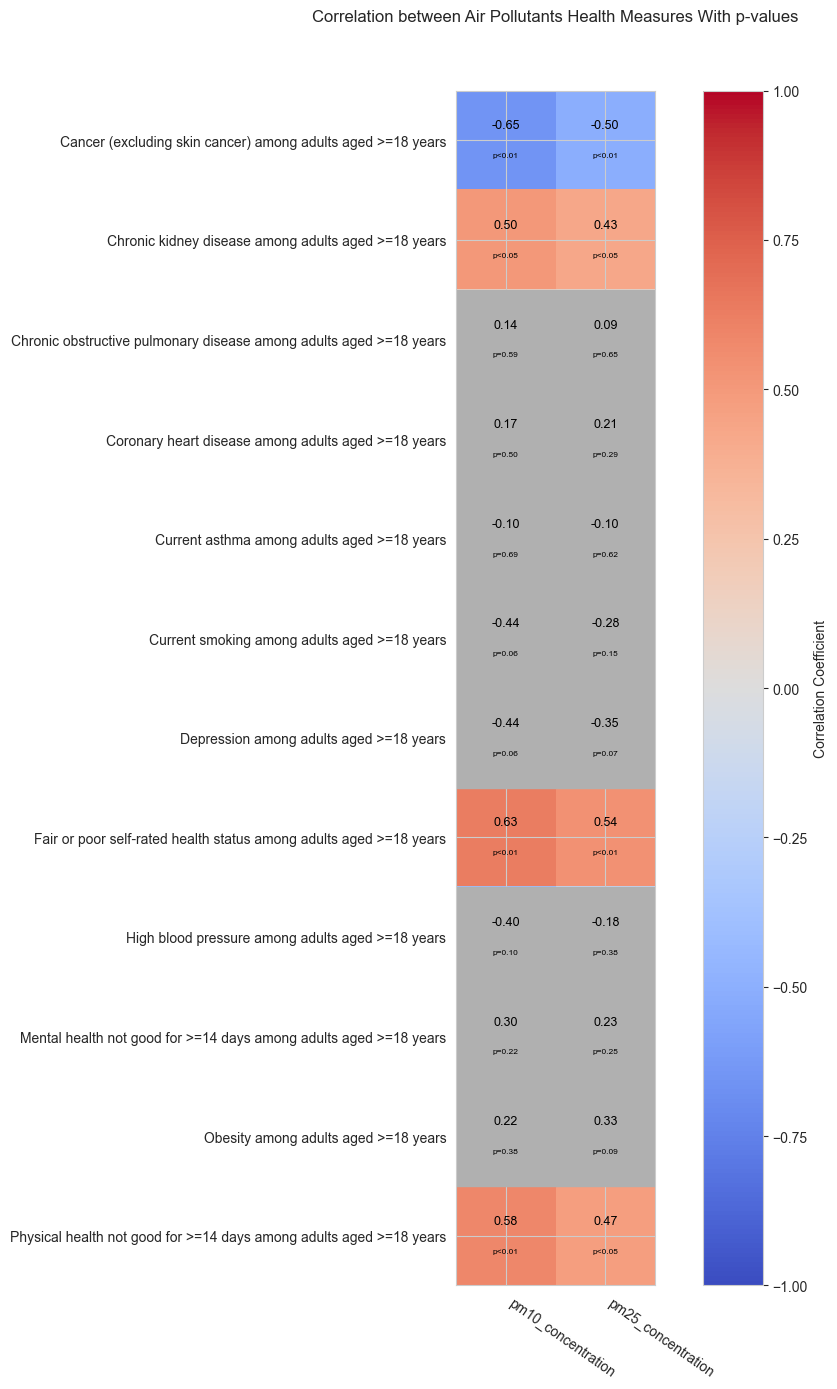

In [341]:
plt.figure(figsize=(10, 14))

# Create the heatmap
im = plt.imshow(disease_pollutant_corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

# Add labels and title
plt.title('Correlation between Air Pollutants Health Measures With p-values', pad=50)
plt.xticks(np.arange(len(pollutants)), pollutants, rotation=-35, ha='left')
plt.yticks(np.arange(len(disease_columns)), disease_columns, rotation=0)

ax = plt.gca()  # Get the current axis

# Add correlation values, p-values, and light gray overlay
for i in range(len(disease_columns)):
    for j in range(len(pollutants)):
        corr_value = disease_pollutant_corr.iloc[i, j]
        p_value = p_value_matrix.iloc[i, j]
        
        # Format the correlation value
        corr_text = f'{corr_value:.2f}'
        
        # Format the p-value
        if pd.notna(p_value):
            if p_value < 0.001:
                p_text = 'p<0.001'
            elif p_value < 0.01:
                p_text = 'p<0.01'
            elif p_value < 0.05:
                p_text = 'p<0.05'
            else:
                p_text = f'p={p_value:.2f}'
        else:
            p_text = 'p=NA'

        # Add text annotations
        plt.text(j, i - 0.15, corr_text, ha="center", va="center", color="black", fontsize=9)
        plt.text(j, i + 0.15, p_text, ha="center", va="center", color="black", fontsize=6)

        # Add LIGHT gray overlay if p-value >= 0.05
        if p_value >= 0.05:
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='#B0B0B0')  # Light gray
            ax.add_patch(rect)

plt.tight_layout()
plt.savefig('corr_weighted_spearman_lightgray.png')
plt.show()

   pm10_concentration  pm25_concentration
0            0.135024            0.092129
1            0.167257            0.211117
2           -0.098653           -0.098934
3           -0.435724           -0.280508
4           -0.443696           -0.350103
5           -0.399022           -0.179549
6            0.299942            0.227095
7            0.215044            0.327226


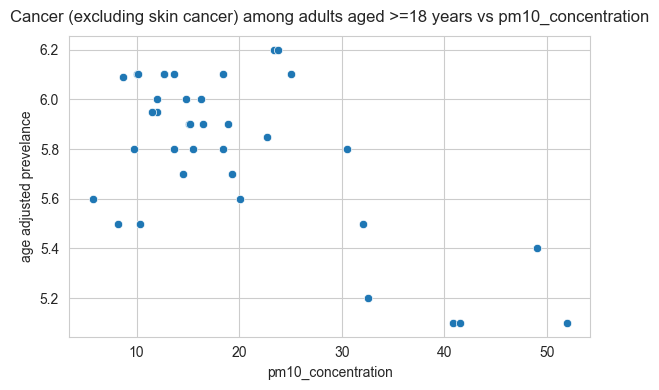

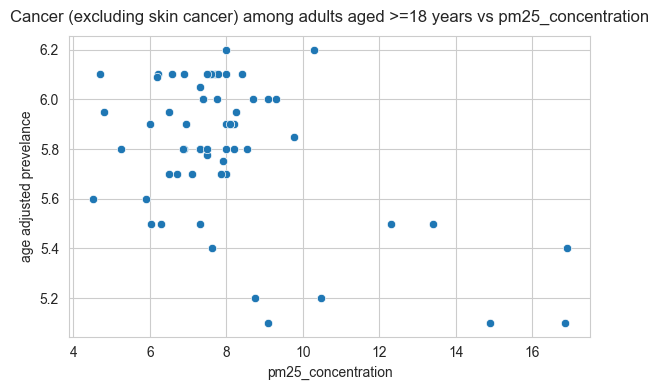

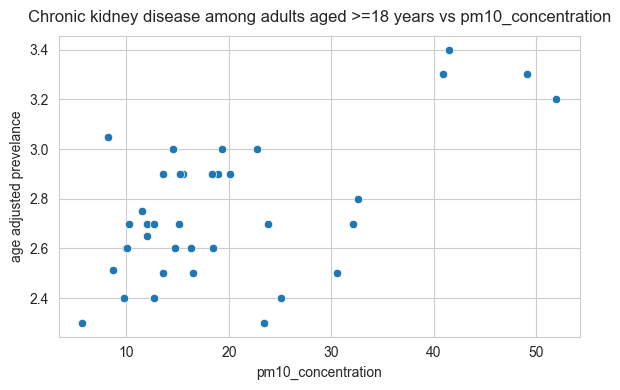

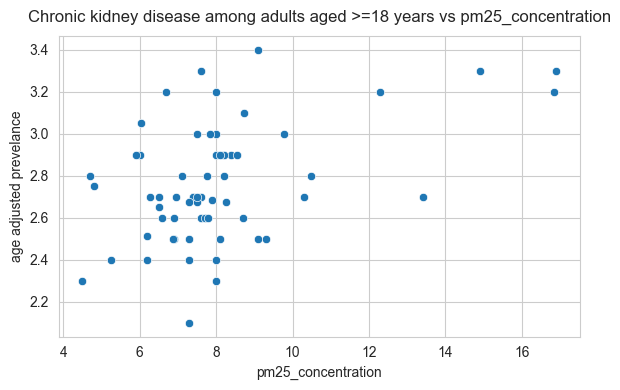

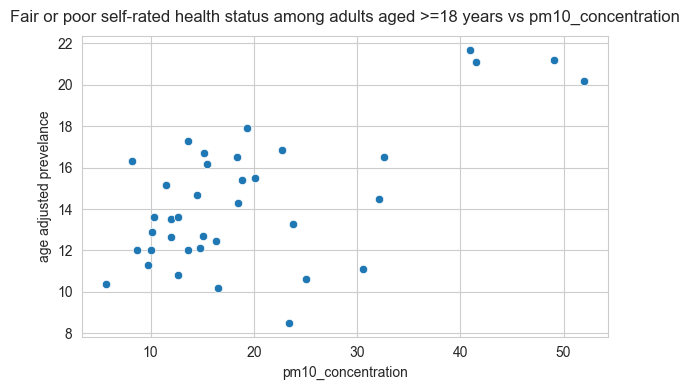

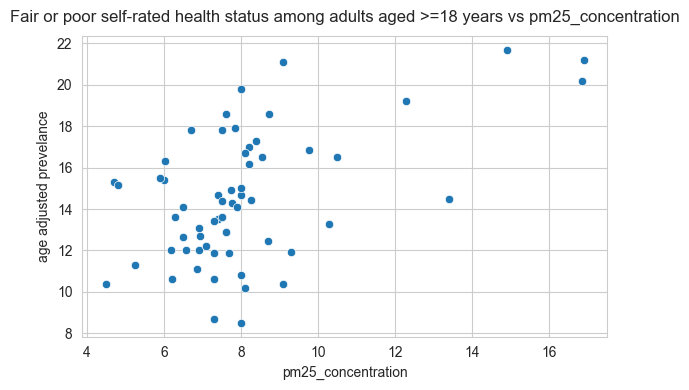

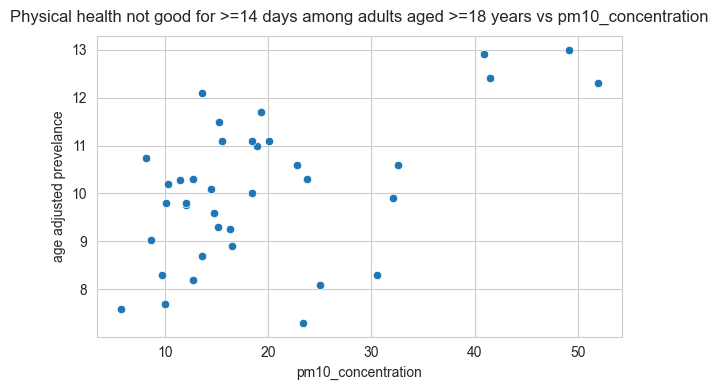

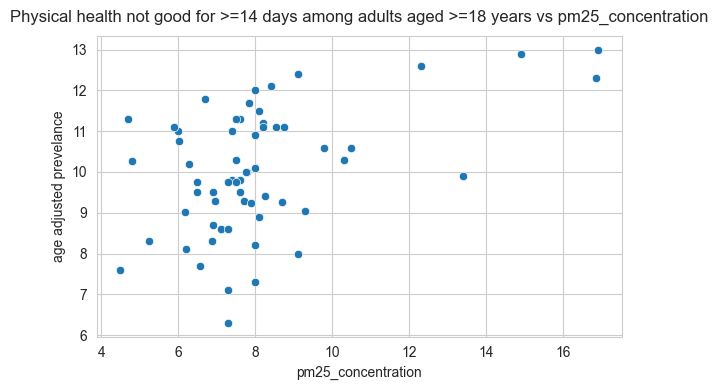

In [ ]:
# insignificant_mask = p_value_matrix > 0.05
# ins_filtered_correlations = correlation_matrix.copy()
# ins_filtered_correlations = ins_filtered_correlations.where(insignificant_mask, np.nan)
# ins_filtered_correlations = ins_filtered_correlations.astype(float)  # Ensure numeric dtype

# ins_filtered_disease_columns = pd.Series(disease_columns, index=correlation_matrix.index)  # Ensure index matches
# invalid_rows = insignificant_mask.any(axis=1)  # Boolean mask for valid rows
# # Apply mask after ensuring indexes match
# ins_filtered_correlations = ins_filtered_correlations.loc[invalid_rows].reset_index(drop=True)
# ins_filtered_disease_columns = ins_filtered_disease_columns.loc[invalid_rows].reset_index(drop=True)

# print(ins_filtered_correlations)

# xd_df= merged_df.copy()
# xd_df=xd_df.drop(ins_filtered_disease_columns,axis=1)


# disease_columns = [
#     "Cancer (excluding skin cancer) among adults aged >=18 years",
#     "Chronic kidney disease among adults aged >=18 years",
#     "Fair or poor self-rated health status among adults aged >=18 years",
#     "Physical health not good for >=14 days among adults aged >=18 years",
# ]

# pollutant_columns = ["pm10_concentration", "pm25_concentration"]  # No no2_concentration

# # Set seaborn style
# sns.set_style("whitegrid")

# # Create scatter plots
# for disease in disease_columns:
#     for pollutant in pollutant_columns:
#         plt.figure(figsize=(6, 4))
#         sns.scatterplot(data=xd_df, x=pollutant, y=disease)
        
#         plt.xlabel(pollutant)
#         plt.ylabel('age adjusted prevelance')
#         plt.title(f"{disease} vs {pollutant}", fontsize=12, pad=10)  # Adjust title placement
        
#         plt.tight_layout()  # Ensures labels don't get cut off
#         plt.show()

## Calculating p-values for the correlation coefficients

In [343]:
# whole_population = np.sum(array[:,numberOfDiseases-1])
# print(whole_population)
# wheighting_array = array[:,numberOfDiseases]/whole_population
# wheighting_array


In [344]:
# #This is a test correlation for one disease 

# X1=array[:,14]*wheighting_array
# Y=array[:,23]
# print(array[:,14])
# print(X1)

# x = X1.astype(float)
# y = Y.astype(float)

# mask = ~np.isnan(y)& ~np.isnan(x)

# Y_filtered=y[mask]
# X1_filtered=x[mask]

# res = stats.pearsonr(X1_filtered, Y_filtered)

# res

Now we want to find out whether the data is normally distributed so that we know how to compute the correlation

We find this result extremely suspicious hence we use different test satatistics for checking normality

Here we find that the data is indeed normally distributed and as KS test is very prone to overinterpretation of outlying values and not suited for large datasets, we trust Shapiro-Wilk test and decide to go for pearson correlation test without permutation

In [345]:
n = array.shape[1]

air_pollution_parameter = [n-3,n-2,n-1]
disease_range_start = 1
disease_range_end = numberOfDiseases

#permutation_model=stats.PermutationMethod(n_resamples=99999, batch=None, random_state=None, rng=None)

# Ensure Corr array matches the range
Corr_p_values = np.zeros((disease_range_end - disease_range_start + 1,len(air_pollution_parameter)))
Corr_coef = np.zeros((disease_range_end - disease_range_start + 1,len(air_pollution_parameter)))

#This computes p-values of pearson correlation test statistic between diseases and different air pollutants and puts it into a 21x3 array
for j in range(0,len(air_pollution_parameter)):
    y = array[:, air_pollution_parameter[j]]

    for i in range(disease_range_start, disease_range_end + 1):
        try:
            # Extract disease column
            a = array[:, i]#*wheighting_array
            
            # Convert to float as datasets are super messy
            a_float = a.astype(float)
            y_float = y.astype(float)
            
            # Create mask for non-NaN values in BOTH columns
            mask =  ~np.isnan(y_float) & ~np.isnan(a_float) 
            
            # Filter both arrays
            y_filtered = y_float[mask]
            a_filtered = a_float[mask]
            
            # Compute Pearson correlation
            res = stats.pearsonr(a_filtered, y_filtered)
            
            Corr_p_values[i - disease_range_start,j] = res.pvalue
            Corr_coef[i - disease_range_start,j]=res.correlation
            
        except Exception as e:
            print(f"Error processing column {i}: {e}")

print(Corr_coef)
Corr_p_values

Error processing column 1: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 2: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 3: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 4: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 5: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 6: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 7: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 8: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 9: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 10: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 11: 'PearsonRResult' object has no attribute 'correlation'
Error processing column 12: 'PearsonRResult' object has no attribute 'correlation'
Error process

c:\Users\anssi\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


array([[7.28392604e-05, 6.20038981e-01, 1.28863878e-04],
       [1.69942675e-04, 9.07269607e-01, 2.19161508e-01],
       [1.62766404e-01, 8.14178631e-02, 2.04911759e-01],
       [1.69881680e-02, 4.82547927e-02, 4.08500620e-01],
       [2.94529390e-01, 3.00660803e-01, 4.33105315e-01],
       [1.50086666e-01, 4.95716970e-02, 3.15633966e-02],
       [4.09127715e-01, 1.33082870e-01, 2.90738890e-02],
       [1.63941890e-05, 9.20597348e-01, 2.00394029e-01],
       [4.42007568e-01, 1.21992713e-01, 5.20715518e-01],
       [8.17435385e-02, 4.00693387e-01, 9.03156444e-01],
       [1.23974324e-01, 6.92595881e-03, 6.78448609e-01],
       [1.83684826e-04, 4.01029686e-01, 6.54811857e-01],
       [           nan,            nan,            nan],
       [7.16523237e-11, 1.58851110e-01, 1.64454018e-01],
       [0.00000000e+00, 5.81232226e-01, 8.05588037e-02],
       [5.81232226e-01, 0.00000000e+00, 8.28237117e-02],
       [8.05588037e-02, 8.28237117e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000

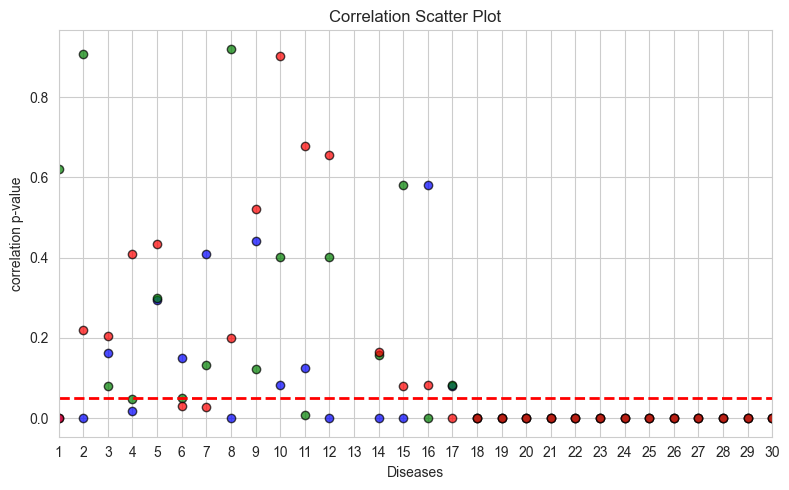

Length of Corr: 30
Length of features: 30


In [346]:
#This creates a scatter plot of diseases and thier p-values

features = np.arange(1, len(Corr_p_values) + 1)



plt.figure(figsize=(8,5))
plt.scatter(features, Corr_p_values[:,0], color='blue', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_p_values[:,1], color='green', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_p_values[:,2], color='red', edgecolors='black', alpha=0.7)
# Red line at y=0.05
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2)

plt.xlim(1, len(Corr_p_values))

plt.xticks(features)

plt.xlabel('Diseases')
plt.ylabel('correlation p-value')
plt.title('Correlation Scatter Plot')

plt.tight_layout()
plt.show()

# Verify lengths
print("Length of Corr:", len(Corr_p_values))
print("Length of features:", len(features))

(30, 3)
(30, 3)
[[7.28392604e-05            nan 1.28863878e-04]
 [1.69942675e-04            nan            nan]
 [           nan            nan            nan]
 [1.69881680e-02 4.82547927e-02            nan]
 [           nan            nan            nan]
 [           nan 4.95716970e-02 3.15633966e-02]
 [           nan            nan 2.90738890e-02]
 [1.63941890e-05            nan            nan]
 [           nan            nan            nan]
 [           nan            nan            nan]
 [           nan 6.92595881e-03            nan]
 [1.83684826e-04            nan            nan]
 [           nan            nan            nan]
 [7.16523237e-11            nan            nan]
 [0.00000000e+00            nan            nan]
 [           nan 0.00000000e+00            nan]
 [           nan            nan 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000

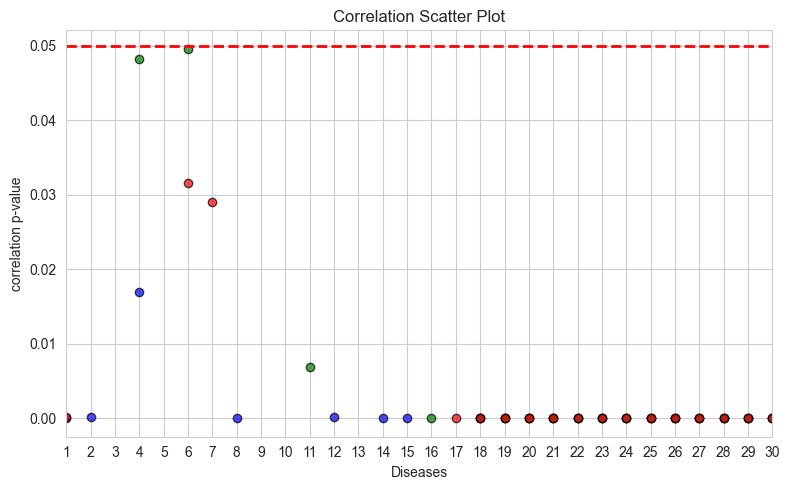

Length of Corr_significant: 30
Length of features: 30


In [347]:
#This filters the Corr matrix so that only statistically significant values (p<=0.05) remain
print(Corr_p_values.shape)

Corr_significat_p=Corr_p_values.copy() #if I dont use copy(), Corr also changes when I change Corr_significant
Corr_significat_p[Corr_significat_p > 0.05] = np.nan
print(Corr_significat_p.shape)
print(Corr_significat_p)

#This creates a scatter plot with statistically significant values

features = np.arange(1, len(Corr_significat_p) + 1)

plt.figure(figsize=(8,5))
plt.scatter(features, Corr_significat_p[:,0], color='blue', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_significat_p[:,1], color='green', edgecolors='black', alpha=0.7)
plt.scatter(features, Corr_significat_p[:,2], color='red', edgecolors='black', alpha=0.7)
# Red line at y=0.05
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2)

plt.xlim(1, len(Corr_p_values))

plt.xticks(features)

plt.xlabel('Diseases')
plt.ylabel('correlation p-value')
plt.title('Correlation Scatter Plot')

plt.tight_layout()
plt.show()

# Verify lengths
print("Length of Corr_significant:", len(Corr_significat_p))
print("Length of features:", len(features))

Now, as I want to present the data as a table I switch to dataframes as it makes it easier

In [348]:
correlation_p_value_df= pd.DataFrame(Corr_p_values, index=disease_columns, columns=pollutants)

significant_correlation_p_value_df = correlation_p_value_df.where(correlation_p_value_df <= 0.05, np.nan)

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=correlation_p_value_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=correlation_p_value_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=significant_correlation_p_value_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=significant_correlation_p_value_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()


ValueError: Shape of passed values is (30, 3), indices imply (4, 2)

Now we want to filter the correlation coefficient data so that it leaves only the statistically signifficant coefficients

In [ ]:
sign_Corr_coef = np.where(Corr_p_values < 0.05, Corr_coef, np.nan)
sign_Corr_coef

correlation_coef_df= pd.DataFrame(Corr_coef, index=disease_columns, columns=pollutants)
sign_correlation_coef_df= pd.DataFrame(sign_Corr_coef, index=disease_columns, columns=pollutants)

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=correlation_coef_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=correlation_coef_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('tight')
ax.axis('off')

ax.table(
    cellText=sign_correlation_coef_df.values, 
    colLabels=["Disease/Air Pollution"] + pollutants, 
    rowLabels=sign_correlation_coef_df.index, 
    cellLoc='center', 
    loc='center'
)
plt.show()

